# Gusto

Acute myocardial infarction (“heart attack”) is caused by the formation of a clot in oneof the coronary arteries that supply blood to the heart muscle. 

Acute MI is a major public health problem. Mortality is substantial in the period immediately after the event (and also during the years after surviving the initial  infarction). Some patients die before reaching the  hospital. Patients seen in hospitals are reported to have an average mortality within 30 days around 6–15%, with improvement over time. The risk of 30-day mortality strongly depends on various prognostic factors. In younger patients, risks are much lower than in older patients. Other patient demographics are also important (gender, length, weight), as well as the presence of risk factors (hypertension, diabetes, smoking, family history) and the history of previous cardiovascular events (previous MI, angina, stroke, bypass surgery). Relevant presenting characteristics includethe location of the infarction and the extent of ECG abnormalities. Very important is the acute state of the patients reflected by blood pressure,heart rate, and left ventricular function (e.g., presence of shock).

Aim of this study is to find predictors of 30-days mortality. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

from pprint import pprint
from time import sleep

#  load data
import pandas as pd
df = pd.read_csv("./Gusto.csv")

# dummify smk categories
df['eversmk']= (df['smk']!=1).astype(int)
df['currentsmk']=(df['smk']==3).astype(int)
df.drop(["smk"], axis=1, inplace=True)
df

,day30,sex,age,a65,killip,sho,dia,hyp,hrt,ant,...,wei,htn,lip,pan,fam,ste,st4,ttr,eversmk,currentsmk
0,0,0,70.313,1,1,0,0,0,0,1,...,84.0,1,1,0,0,1,0,1,1,1
1,0,0,59.844,0,1,0,1,0,0,1,...,115.0,1,0,0,1,6,1,0,0,0
2,0,0,59.023,0,1,0,0,0,1,0,...,76.0,1,0,0,1,3,0,0,0,0
3,1,1,80.375,1,1,0,0,0,1,0,...,50.0,0,0,0,0,3,0,0,1,1
4,0,0,64.750,0,1,0,0,1,0,0,...,97.4,0,0,1,1,2,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3656,0,0,51.836,0,1,0,0,0,0,1,...,65.0,0,0,0,0,7,1,1,0,0
3657,0,0,51.836,0,1,0,1,0,0,1,...,72.1,0,0,1,0,7,1,1,1,1
3658,0,0,63.977,0,1,0,0,0,0,0,...,87.2,1,0,0,0,2,0,1,1,0
3659,0,1,59.758,0,1,0,0,0,0,0,...,57.8,0,0,0,0,6,1,1,1,1


In [2]:
# any null value?
bool(df.isnull().sum().sum())

False

In [3]:
# dropping useless/redundant columns
df.drop(["sho", "a65", "st4"], axis=1, inplace=True)
df.columns

Index(['day30', 'sex', 'age', 'killip', 'dia', 'hyp', 'hrt', 'ant', 'pmi',
       'hei', 'wei', 'htn', 'lip', 'pan', 'fam', 'ste', 'ttr', 'eversmk',
       'currentsmk'],
      dtype='object')

## Question 1

*Build a descriptive table, comparing patients deadversuspatients alive at 30 days. Insert also a column with the total population descriptive statistics.*




''

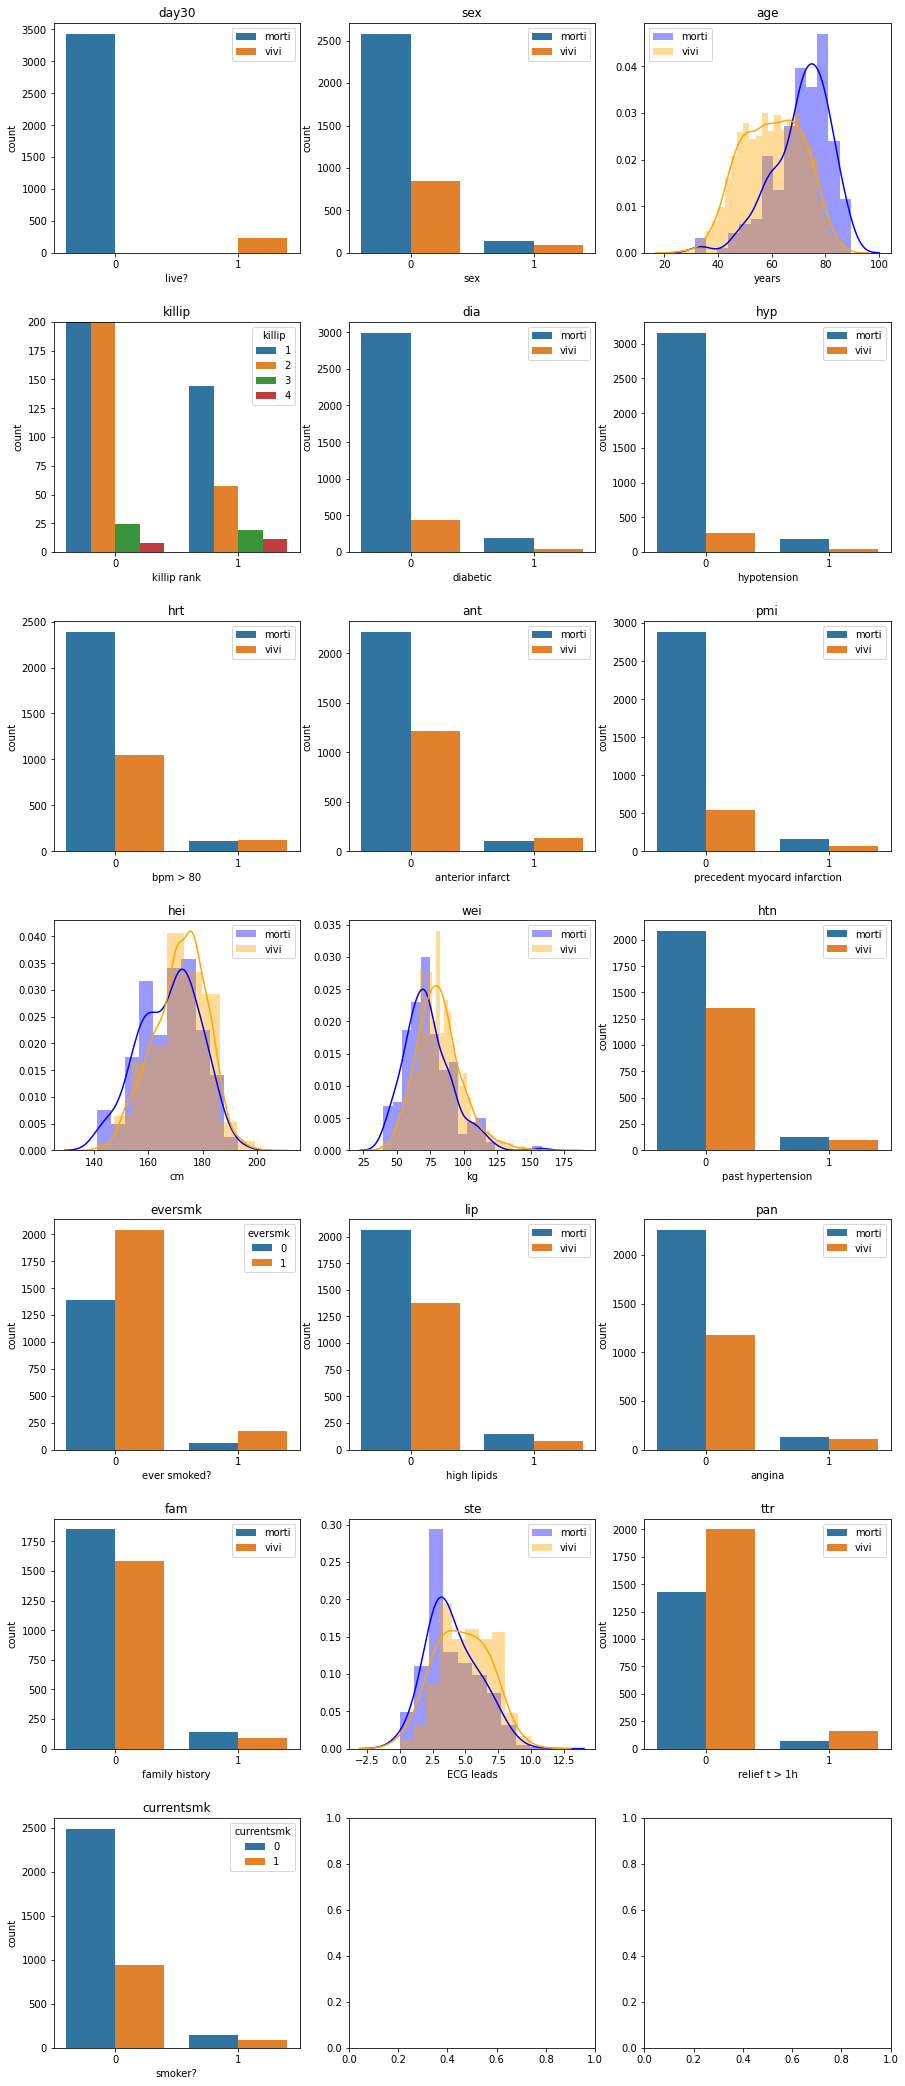

In [4]:
# quick overview
#print(df.describe())

import matplotlib.pyplot as plt
import seaborn as sns

fig, ((a11,a12,a13),
      (a21,a22,a23), 
      (a31,a32,a33),
      (a41,a42,a43),
      (a51,a52,a53),
      (a61,a62,a63),
      (a71,_  ,_  ))= plt.subplots(7,3, figsize=(15,15))


var = "day30"
#a11.hist(df[var], bins=2)
sns.countplot(x='day30',hue='day30',data=df, ax=a11)
a11.set_title(var)
a11.legend(["morti","vivi"])
a11.set_xlabel("vivo?")

sns.countplot(x='day30',hue='sex',data=df, ax=a12)
a12.set_title("sex")
a12.legend(["morti","vivi"])
a12.set_xlabel("sex")

sns.distplot( df.loc[df.day30==1, 'age'] , color="blue", label="0", ax=a13)
sns.distplot( df.loc[df.day30==0, 'age'] , color="orange", label="1", ax=a13)
a13.set_title("age")
a13.set_xlabel("years")
a13.legend(["morti","vivi"])

var = "killip"
a21.set_ylim([0,200])
sns.countplot(x='day30',hue='killip',data=df, ax=a21)
a21.set_title("killip")
a21.set_xlabel("killip rank")


sns.countplot(x='day30',hue='dia',data=df, ax=a22)
a22.set_title("dia")
a22.legend(["morti","vivi"])
a22.set_xlabel("diabetic")


sns.countplot(x='day30',hue='hyp',data=df, ax=a23)
a23.set_title("hyp")
a23.legend(["morti","vivi"])
a23.set_xlabel("hypotension")

sns.countplot(x='day30',hue='hrt',data=df, ax=a31)
a31.set_title("hrt")
a31.legend(["morti","vivi"])
a31.set_xlabel("bpm > 80")

sns.countplot(x='day30',hue='ant',data=df, ax=a32)
a32.set_title("ant")
a32.legend(["morti","vivi"])
a32.set_xlabel("anterior infarct")

sns.countplot(x='day30',hue='pmi',data=df, ax=a33)
a33.set_title("pmi")
a33.legend(["morti","vivi"])
a33.set_xlabel("precedent myocard infarction")

sns.distplot( df.loc[df.day30==1, 'hei'] , color="blue", label="0", ax=a41, bins=10)
sns.distplot( df.loc[df.day30==0, 'hei'] , color="orange", label="1", ax=a41, bins=10)
a41.set_title("hei")
a41.legend(["morti","vivi"])
a41.set_xlabel("cm")

sns.distplot( df.loc[df.day30==1, 'wei'] , color="blue", label="0", ax=a42)
sns.distplot( df.loc[df.day30==0, 'wei'] , color="orange", label="1", ax=a42)
a42.set_title("wei")
a42.legend(["morti","vivi"])
a42.set_xlabel("kg")

sns.countplot(x='day30',hue='htn',data=df, ax=a43)
a43.set_title("htn")
a43.legend(["morti","vivi"])
a43.set_xlabel("past hypertension")

sns.countplot(x='day30',hue='eversmk',data=df, ax=a51)
a51.set_title("eversmk")
a51.set_xlabel("ever smoked?")

sns.countplot(x='day30',hue='lip',data=df, ax=a52)
a52.set_title("lip")
a52.legend(["morti","vivi"])
a52.set_xlabel("high lipids")

sns.countplot(x='day30',hue='pan',data=df, ax=a53)
a53.set_title("pan")
a53.legend(["morti","vivi"])
a53.set_xlabel("angina")

sns.countplot(x='day30',hue='fam',data=df, ax=a61)
a61.set_title("fam")
a61.legend(["morti","vivi"])
a61.set_xlabel("family history")

sns.distplot( df.loc[df.day30==0, 'ste'] , color="blue", label="0", ax=a62, kde_kws={"bw":1}, bins=10)
sns.distplot( df.loc[df.day30==1, 'ste'] , color="orange", label="1", ax=a62, kde_kws={"bw":1}, bins=10)
a62.set_title("ste")
a62.legend(["morti","vivi"])
a62.set_xlabel("ECG leads")

sns.countplot(x='day30',hue='ttr',data=df, ax=a63)
a63.set_title("ttr")
a63.legend(["morti","vivi"])
a63.set_xlabel("relief t > 1h")

sns.countplot(x='day30',hue='currentsmk',data=df, ax=a71)
a71.set_title("currentsmk")
a71.set_xlabel("smoker?")


plt.subplots_adjust(wspace = 0.2, hspace=0.3, top=2)

a11.set_xlabel('live?')
""

## check for multicollinearity

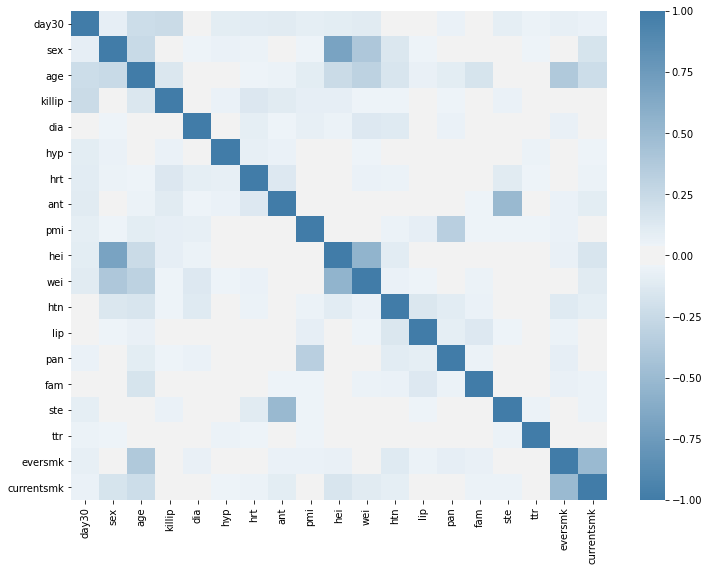

In [5]:
plt.figure(figsize=(12, 9))
sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(240, 240, n=256))

Analizzando la correlazione tra variabili, vediamo come alcune coppie di variabili siano correlate:

* age <-> hei <-> sex <-> wei  (prevedibilmente. valutare di unificarle?)
* age <-> smoke  (comprensibilmente)
* currentsmoke <-> eversmoke (è dura smettere)
* age <-> sex  (questa è da indagare)
* ste <-> ant  (anomalie ECG in caso di infarti precedenti?)
* pan <-> pmi  (angina e infarti al miocardio)

## Question 2

*Perform univariable logistic regression analyses, of all candidate predictors for your model. Optional:For Age is the linearity effect reasonable? How could you model alternatively the age effect?



# Univariate logistic regressions

*Perform univariable logistic regressionanalyses, of all candidate predictors for your model. Optional:For Age is the linearity effect reasonable?How could you model alternativelythe age effect?*

In [6]:

#  logistic regression function

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt


def LRplot(lr, xmi, xma):
    
    #if lr.coef_.shape!=(1,1): return
    
    Xi = np.linspace(xmi,xma,10)
    yi = lr.predict(Xi[:, np.newaxis])
    ypi = lr.predict_proba(Xi[:, np.newaxis])[:,1]
    print(Xi.astype(list),ypi.astype(list))
    # double scatterplot of prediction ad prediction probabilities    
    sns.scatterplot(Xi.astype(list),yi.astype(list))
    sns.scatterplot(list(Xi), list(ypi))
    
   

# relative weight of a false negative
weight=15 # times a false positive


def LR(candidates):
    # subset covariates and outcome
    X = df[candidates]
    y = df.day30
    print("n={}".format(len(X)))
    
    # split data in 80% train / 20% test
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=0)
    # instantiate a regressor
    logistic_regression= LogisticRegression(solver='lbfgs', class_weight={0:1,1:weight})
    # fit on data
    logistic_regression.fit(X_train,y_train)
    # predict
    y_pred=logistic_regression.predict(X_test)
    # compute confusion matrix
    confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
    plt.figure(figsize=(3, 2))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
    # compute metrics
    precision, recall, F1score, support = tuple(metrics.precision_recall_fscore_support(y_test, y_pred))
    # print metrics    
    print('Precision-> vivi:{:.4} morti:{:.4}, \nRecall->    vivi:{:.4} morti:{:.4}, \
          \nF1-Score->  vivi:{:.4} morti:{:.4}, \nSupport->   vivi:{}   morti:{} \n\n'.format(precision[0], precision[1], 
                                                                                         recall[0], recall[1], 
                                                                                         F1score[0], F1score[1], 
                                                                                         support[0], support[1]))    
    #show plot
    plt.show()
    return logistic_regression, X, y, 



 ##############################    sex    ############################## 

n=3661
Precision-> vivi:0.9436 morti:0.1056, 
Recall->    vivi:0.7517 morti:0.3947,           
F1-Score->  vivi:0.8368 morti:0.1667, 
Support->   vivi:1023   morti:76 




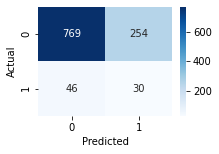

LogisticRegression(C=1.0, class_weight={0: 1, 1: 15}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    age    ############################## 

n=3661
Precision-> vivi:0.9654 morti:0.1356, 
Recall->    vivi:0.6823 morti:0.6711,           
F1-Score->  vivi:0.7995 morti:0.2257, 
Support->   vivi:1023   morti:76 




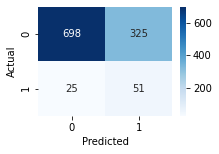

LogisticRegression(C=1.0, class_weight={0: 1, 1: 15}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    killip    ############################## 

n=3661
Precision-> vivi:0.9501 morti:0.1835, 
Recall->    vivi:0.8739 morti:0.3816,           
F1-Score->  vivi:0.9104 morti:0.2479, 
Support->   vivi:1023   morti:76 




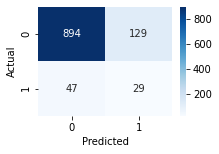

LogisticRegression(C=1.0, class_weight={0: 1, 1: 15}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    dia    ############################## 

n=3661
Precision-> vivi:0.9359 morti:0.1014, 
Recall->    vivi:0.87 morti:0.1974,           
F1-Score->  vivi:0.9017 morti:0.1339, 
Support->   vivi:1023   morti:76 




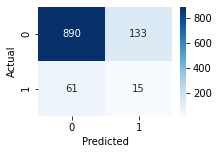

LogisticRegression(C=1.0, class_weight={0: 1, 1: 15}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    hyp    ############################## 

n=3661
Precision-> vivi:0.9372 morti:0.1354, 
Recall->    vivi:0.9189 morti:0.1711,           
F1-Score->  vivi:0.9279 morti:0.1512, 
Support->   vivi:1023   morti:76 




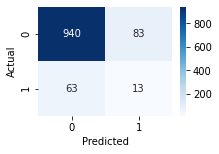

LogisticRegression(C=1.0, class_weight={0: 1, 1: 15}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    hrt    ############################## 

n=3661
Precision-> vivi:0.938 morti:0.08615, 
Recall->    vivi:0.7097 morti:0.3684,           
F1-Score->  vivi:0.808 morti:0.1397, 
Support->   vivi:1023   morti:76 




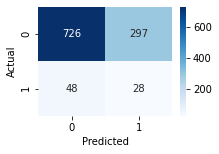

LogisticRegression(C=1.0, class_weight={0: 1, 1: 15}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    ant    ############################## 

n=3661
Precision-> vivi:0.9519 morti:0.1105, 
Recall->    vivi:0.6774 morti:0.5395,           
F1-Score->  vivi:0.7915 morti:0.1834, 
Support->   vivi:1023   morti:76 




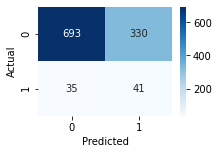

LogisticRegression(C=1.0, class_weight={0: 1, 1: 15}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    pmi    ############################## 

n=3661
Precision-> vivi:0.9363 morti:0.09574, 
Recall->    vivi:0.8338 morti:0.2368,           
F1-Score->  vivi:0.8821 morti:0.1364, 
Support->   vivi:1023   morti:76 




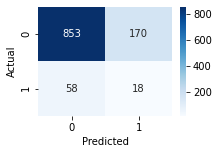

LogisticRegression(C=1.0, class_weight={0: 1, 1: 15}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    hei    ############################## 

n=3661
Precision-> vivi:0.9395 morti:0.08505, 
Recall->    vivi:0.653 morti:0.4342,           
F1-Score->  vivi:0.7705 morti:0.1422, 
Support->   vivi:1023   morti:76 




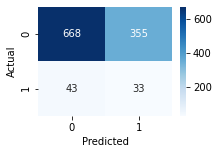

LogisticRegression(C=1.0, class_weight={0: 1, 1: 15}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    wei    ############################## 

n=3661
Precision-> vivi:0.9571 morti:0.1111, 
Recall->    vivi:0.6325 morti:0.6184,           
F1-Score->  vivi:0.7616 morti:0.1884, 
Support->   vivi:1023   morti:76 




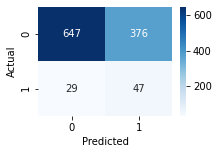

LogisticRegression(C=1.0, class_weight={0: 1, 1: 15}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    htn    ############################## 

n=3661
Precision-> vivi:0.93 morti:0.06809, 
Recall->    vivi:0.5718 morti:0.4211,           
F1-Score->  vivi:0.7082 morti:0.1172, 
Support->   vivi:1023   morti:76 




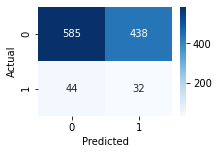

LogisticRegression(C=1.0, class_weight={0: 1, 1: 15}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    lip    ############################## 

n=3661
Precision-> vivi:0.9308 morti:0.0, 
Recall->    vivi:1.0 morti:0.0,           
F1-Score->  vivi:0.9642 morti:0.0, 
Support->   vivi:1023   morti:76 




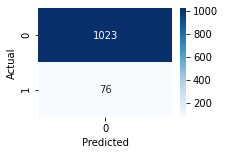

LogisticRegression(C=1.0, class_weight={0: 1, 1: 15}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    pan    ############################## 

n=3661
Precision-> vivi:0.9441 morti:0.09227, 
Recall->    vivi:0.6442 morti:0.4868,           
F1-Score->  vivi:0.7658 morti:0.1551, 
Support->   vivi:1023   morti:76 




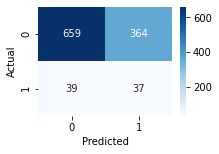

LogisticRegression(C=1.0, class_weight={0: 1, 1: 15}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    fam    ############################## 

n=3661
Precision-> vivi:0.9413 morti:0.07881, 
Recall->    vivi:0.4858 morti:0.5921,           
F1-Score->  vivi:0.6409 morti:0.1391, 
Support->   vivi:1023   morti:76 




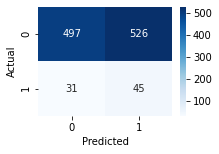

LogisticRegression(C=1.0, class_weight={0: 1, 1: 15}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    ste    ############################## 

n=3661
Precision-> vivi:0.9534 morti:0.11, 
Recall->    vivi:0.6598 morti:0.5658,           
F1-Score->  vivi:0.7799 morti:0.1842, 
Support->   vivi:1023   morti:76 




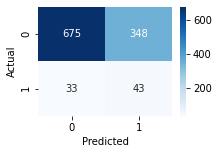

LogisticRegression(C=1.0, class_weight={0: 1, 1: 15}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    ttr    ############################## 

n=3661
Precision-> vivi:0.9451 morti:0.08, 
Recall->    vivi:0.4379 morti:0.6579,           
F1-Score->  vivi:0.5985 morti:0.1427, 
Support->   vivi:1023   morti:76 




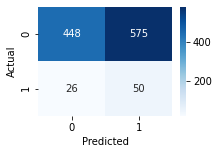

LogisticRegression(C=1.0, class_weight={0: 1, 1: 15}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    eversmk    ############################## 

n=3661
Precision-> vivi:0.9523 morti:0.08464, 
Recall->    vivi:0.4291 morti:0.7105,           
F1-Score->  vivi:0.5916 morti:0.1513, 
Support->   vivi:1023   morti:76 




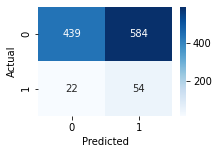

LogisticRegression(C=1.0, class_weight={0: 1, 1: 15}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 ##############################    currentsmk    ############################## 

n=3661
Precision-> vivi:0.9388 morti:0.08889, 
Recall->    vivi:0.7195 morti:0.3684,           
F1-Score->  vivi:0.8146 morti:0.1432, 
Support->   vivi:1023   morti:76 




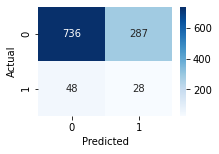

LogisticRegression(C=1.0, class_weight={0: 1, 1: 15}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [7]:
#for col in df.columns[1:]:
for col in ['sex', 'age', 'killip', 'dia', 'hyp', 'hrt', 'ant', 'pmi',
       'hei', 'wei', 'htn', 'lip', 'pan', 'fam', 'ste', 'ttr', 'eversmk','currentsmk']:
    print("\n\n","#"*30,"  " ,str(col), "  ","#"*30,"\n")
    lr, X, y = LR([str(col)])
    print(lr)
    

n=3661
Precision-> vivi:0.9671 morti:0.1763, 
Recall->    vivi:0.7761 morti:0.6447,           
F1-Score->  vivi:0.8612 morti:0.2768, 
Support->   vivi:1023   morti:76 




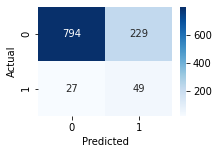

LogisticRegression(C=1.0, class_weight={0: 1, 1: 15}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
coefficients: [array([-0.46458609,  0.08624171,  0.78094389,  0.02884352,  1.15389645,
        0.91370398,  0.4238709 ,  0.6022196 , -0.04235064, -0.01189495,
        0.1987264 ,  0.13211493, -0.02572094,  0.07724445,  0.12297859,
        0.37635758, -0.21136127, -0.00429949])]
intercept: [-0.20717903]


In [8]:
# full model

lr, X, y = LR(df.columns[1:])
print(lr)
print("coefficients: {}".format(list(lr.coef_)))
print("intercept: {}".format(lr.intercept_))

## Question 3

*Build  a multivariable  logistic  regression model  starting from the list of significant predictors at univariable analyses. Pay attention to multicollinearity (same variables recoded in different ways).* 



n=3661
Precision-> vivi:0.9671 morti:0.1763, 
Recall->    vivi:0.7761 morti:0.6447,           
F1-Score->  vivi:0.8612 morti:0.2768, 
Support->   vivi:1023   morti:76 




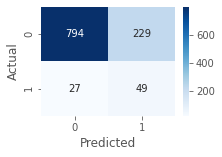

LogisticRegression(C=1.0, class_weight={0: 1, 1: 15}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
coefficients =
[('sex', -0.46458608624222275),
 ('age', 0.08624170528095083),
 ('killip', 0.7809438879005246),
 ('dia', 0.028843522979157984),
 ('hyp', 1.153896449808182),
 ('hrt', 0.9137039820247124),
 ('ant', 0.42387090141770334),
 ('pmi', 0.602219597399233),
 ('hei', -0.042350636464429055),
 ('wei', -0.011894951819362495),
 ('htn', 0.19872639743493442),
 ('lip', 0.13211492581412582),
 ('pan', -0.02572094448112624),
 ('fam', 0.07724444561123461),
 ('ste', 0.12297858894466622),
 ('ttr', 0.3763575805369658),
 ('eversmk', -0.2113612707396436),
 ('currentsmk', -0.004299493874543761)]
'intercept: [-0.20717903]'


In [27]:
# full model
covar = ['sex', 'age', 'killip', 'dia', 'hyp', 'hrt', 'ant', 'pmi',
       'hei', 'wei', 'htn',  'lip', 'pan', 'fam', 'ste', 'ttr','eversmk','currentsmk']

fullModel, X1, y1 = LR(covar)
print(fullModel)

print("coefficients =")
pprint(list(zip(covar,fullModel.coef_.tolist()[0])))
pprint("intercept: {}".format(fullModel.intercept_))


# removing multicollinear variables

* `age <-> hei <-> sex <-> wei`  (prevedibilmente)
* `age <-> smoke`  (comprensibilmente)
* `age <-> sex`  (questa è da indagare)
* `ste <-> ant`  (anomalie ECG in caso di infarti precedenti?)
* `pan <-> pmi`  (angina e infarti al miocardio)



* Removing: `'hei','wei','age'`, leaving `'sex'` and `'smoke'`
* Removing: `'pan'`, leaving `'pmi'`
* Removing: `'ste'`, leaving `'ant'`

n=3661
Precision-> vivi:0.9624 morti:0.1642, 
Recall->    vivi:0.7761 morti:0.5921,           
F1-Score->  vivi:0.8593 morti:0.2571, 
Support->   vivi:1023   morti:76 




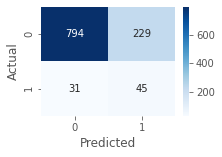

LogisticRegression(C=1.0, class_weight={0: 1, 1: 15}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
coefficients =
[('sex', 0.7890607247322533),
 ('killip', 0.9057103437271595),
 ('hyp', 1.1010560393927524),
 ('hrt', 0.32879039434277785),
 ('pmi', 0.805887393067348),
 ('ttr', 0.36634534411012554),
 ('ant', 0.7476052505643761),
 ('dia', -0.2227006793214892),
 ('hrt', 0.32879039434277785),
 ('fam', -0.3600228868631063),
 ('htn', 0.2001333589080452),
 ('lip', -0.301867363255721),
 ('eversmk', 0.5737128162914925),
 ('currentsmk', 0.03588282864569439)]
'intercept: [-2.85408495]'


In [28]:
# pruned model
covar = ['sex', 'killip', 'hyp', 'hrt', 'pmi',  
         'ttr','ant','dia', 'hrt', 'fam', 'htn', 
         'lip', 'eversmk', 'currentsmk']

prunedModel, X2, y2 = LR(covar)
print(prunedModel)


print("coefficients =")
pprint(list(zip(covar,prunedModel.coef_.tolist()[0])))
pprint("intercept: {}".format(prunedModel.intercept_))

## Question 4 

*Evaluate model performance in discrimination by means of the AUC under the ROC curve. Evaluate also model performance in terms of calibration.* 



findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


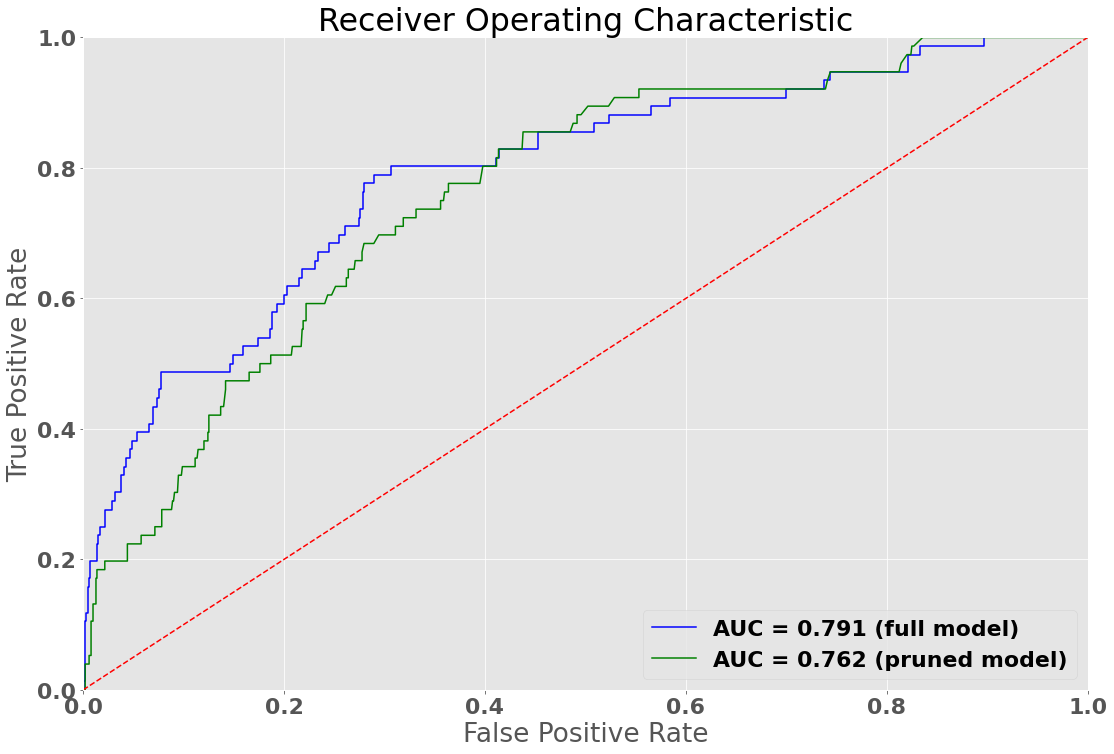

In [33]:

#split data in 80% train / 20% test
X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y1,test_size=0.30,random_state=0)
X2_train,X2_test,y2_train,y2_test = train_test_split(X2,y2,test_size=0.30,random_state=0)

# calculate the fpr and tpr for all thresholds of the classification
full_probs = fullModel.predict_proba(X1_test)
pruned_probs = prunedModel.predict_proba(X2_test)

full_preds = full_probs[:,1]
pruned_preds = pruned_probs[:,1]


fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, full_preds)
fpr2, tpr2, threshold2 = metrics.roc_curve(y_test, pruned_preds)

roc_auc1 = metrics.auc(fpr1, tpr1)
roc_auc2 = metrics.auc(fpr2, tpr2)




import matplotlib.pyplot as plt
plt.figure(figsize=(18,12))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.3f (full model)' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC = %0.3f (pruned model)' % roc_auc2)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 48}

matplotlib.rc('font', **font)

plt.show()


5) Represent the estimated model by means of a nomogram (hint: R function nomogram {rms})

Niente nomogrammi su python, però ho fatto un widget interattivo.

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


n=3661
Precision-> vivi:0.9685 morti:0.1825, 
Recall->    vivi:0.781 morti:0.6579,           
F1-Score->  vivi:0.8647 morti:0.2857, 
Support->   vivi:1023   morti:76 




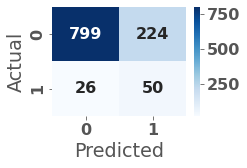

interactive(children=(Dropdown(description='sex', options=('M', 'F'), value='M'), IntSlider(value=2, descripti…

In [36]:
# pruned model
covar = ['sex', 'killip', 'age', 'hyp', 'hrt', 'pmi',  
         'ttr','ant','dia', 'fam', 'htn', 'lip', 'eversmk', 'currentsmk']

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

lr, X, y = LR(covar)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


@interact(sex=["M","F"],   # sex
          killipClass=(1,4,1),  # killip
          age=(0,120,1), # age
          hypotension=False, # hyp
          tachycardia=False, # hrt
          previousMiocardialInfarction=False, # pmi          
          chestPainReliefTimeMoreThan1H=False, # ttr
          anteriorInfarctLocation=False, # ant
          diabetic=False, # dia
          familyHistoryOfMI=False, # fam
          hypertensionHistory=False, # htn
          hypercholesterilemia=False,
          everSmoke=False,
          currentSmoker=False) # lip

def pred(sex,killipClass,age,hypotension,tachycardia,previousMiocardialInfarction,
          chestPainReliefTimeMoreThan1H,anteriorInfarctLocation,diabetic,familyHistoryOfMI, 
          hypertensionHistory,hypercholesterilemia, everSmoke, currentSmoker):
    
    sex= 1 if sex == 'F' else 0
    
    covariates = np.array([sex,killipClass,age,hypotension,tachycardia,previousMiocardialInfarction, 
          chestPainReliefTimeMoreThan1H,anteriorInfarctLocation,diabetic,familyHistoryOfMI, 
          hypertensionHistory,hypercholesterilemia, everSmoke,currentSmoker])
    
    prediction = lr.predict([covariates.astype(int)]), 
    prob =       lr.predict_proba([covariates.astype(int)])

  
    print("covariates:", covariates)
    print("p(morte)= {:.3}%".format(prob[0][1]*100))
    return



## Question 6

6) Internally validate the estimated model (hint: R function  validate {rms})



In [41]:
from sklearn.linear_model import LogisticRegressionCV
X = df[['sex', 'age', 'killip', 'dia', 'hyp', 'hrt', 'ant', 'pmi',
       'hei', 'wei', 'htn', 'lip', 'pan', 'fam', 'ste', 'ttr', 'eversmk',
       'currentsmk']]
y = df[['day30']]

In [56]:
@interact(metric = metrics.SCORERS.keys())

def test(metric):
    clf = LogisticRegressionCV(cv=10, random_state=0, scoring = metric).fit(X, y)
    print("metric: {}, score = {:.4}".format(metric,clf.score(X, y)))

interactive(children=(Dropdown(description='metric', options=('explained_variance', 'r2', 'max_error', 'neg_me…

## Question 7

*Setting  aside  the  interpretability  of  the  model, are  you  able  to  find  a  machine learning algorithm that predicts the risk of event with a similar (or better) performance than the logistic model*

In [57]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier

class XGBoostWithEarlyStop(BaseEstimator):
    def __init__(self, early_stopping_rounds=5, test_size=0.1, 
                 eval_metric='mae', **estimator_params):
        self.early_stopping_rounds = early_stopping_rounds
        self.test_size = test_size
        self.eval_metric=eval_metric='mae'        
        if self.estimator is not None:
            self.set_params(**estimator_params)

    def set_params(self, **params):
        return self.estimator.set_params(**params)

    def get_params(self, **params):
        return self.estimator.get_params()

    def fit(self, X, y):
        x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size)
        self.estimator.fit(x_train, y_train, 
                           early_stopping_rounds=self.early_stopping_rounds, 
                           eval_metric=self.eval_metric, eval_set=[(x_val, y_val)])
        return self

    def predict(self, X):
        return self.estimator.predict(X)

class XGBoostRegressorWithEarlyStop(XGBoostWithEarlyStop):
    def __init__(self, *args, **kwargs):
        self.estimator = XGBRegressor()
        super(XGBoostRegressorWithEarlyStop, self).__init__(*args, **kwargs)

class XGBoostClassifierWithEarlyStop(XGBoostWithEarlyStop):
    def __init__(self, *args, **kwargs):
        self.estimator = XGBClassifier()
        super(XGBoostClassifierWithEarlyStop, self).__init__(*args, **kwargs)

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

x = df[['sex', 'age', 'killip', 'dia', 'hyp', 'hrt', 'ant', 'pmi',
       'hei', 'wei', 'htn', 'lip', 'pan', 'fam', 'ste', 'ttr', 'eversmk',
       'currentsmk']]
y = df[['day30']]

print(x.shape, y.shape)

(3661, 18) (3661, 1)


In [100]:
pipe = Pipeline([
    ('pca', PCA(5)),
    ('xgb', XGBoostRegressorWithEarlyStop())
])

param_grid = {
    'pca__n_components': [3, 5, 7, 9, 11, 13, 15],
    'xgb__n_estimators': [50, 70, 90, 110, 130]
}

grid = GridSearchCV(pipe, param_grid, scoring='neg_mean_absolute_error')
grid.fit(x, y)
print(grid.best_params_)

[0]	validation_0-mae:0.37457
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.28860
[2]	validation_0-mae:0.23046
[3]	validation_0-mae:0.18835
[4]	validation_0-mae:0.15930
[5]	validation_0-mae:0.13836
[6]	validation_0-mae:0.12377
[7]	validation_0-mae:0.11321
[8]	validation_0-mae:0.10567
[9]	validation_0-mae:0.09991
[10]	validation_0-mae:0.09617
[11]	validation_0-mae:0.09368
[12]	validation_0-mae:0.09207
[13]	validation_0-mae:0.09049
[14]	validation_0-mae:0.08866
[15]	validation_0-mae:0.08761
[16]	validation_0-mae:0.08590
[17]	validation_0-mae:0.08535
[18]	validation_0-mae:0.08517
[19]	validation_0-mae:0.08502
[20]	validation_0-mae:0.08526
[21]	validation_0-mae:0.08503
[22]	validation_0-mae:0.08446
[23]	validation_0-mae:0.08452
[24]	validation_0-mae:0.08380
[25]	validation_0-mae:0.08440
[26]	validation_0-mae:0.08434
[27]	validation_0-mae:0.08442
[28]	validation_0-mae:0.08483
[29]	validation_0-mae:0.08350
[30]	validation_0-mae:0.08353
[31]	validation_0

[19]	validation_0-mae:0.09050
[20]	validation_0-mae:0.08991
[21]	validation_0-mae:0.08884
[22]	validation_0-mae:0.08833
[23]	validation_0-mae:0.08789
[24]	validation_0-mae:0.08741
[25]	validation_0-mae:0.08723
[26]	validation_0-mae:0.08692
[27]	validation_0-mae:0.08649
[28]	validation_0-mae:0.08618
[29]	validation_0-mae:0.08617
[30]	validation_0-mae:0.08551
[31]	validation_0-mae:0.08543
[32]	validation_0-mae:0.08541
[33]	validation_0-mae:0.08500
[34]	validation_0-mae:0.08458
[35]	validation_0-mae:0.08479
[36]	validation_0-mae:0.08491
[37]	validation_0-mae:0.08494
[38]	validation_0-mae:0.08469
[39]	validation_0-mae:0.08458
Stopping. Best iteration:
[34]	validation_0-mae:0.08458

[0]	validation_0-mae:0.39049
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.31226
[2]	validation_0-mae:0.25918
[3]	validation_0-mae:0.22114
[4]	validation_0-mae:0.19539
[5]	validation_0-mae:0.17554
[6]	validation_0-mae:0.16251
[7]	validation_0-mae:0.15359
[8]	validation_0-m

[20]	validation_0-mae:0.08447
[21]	validation_0-mae:0.08452
[22]	validation_0-mae:0.08446
[23]	validation_0-mae:0.08406
[24]	validation_0-mae:0.08400
[25]	validation_0-mae:0.08407
[26]	validation_0-mae:0.08379
[27]	validation_0-mae:0.08389
[28]	validation_0-mae:0.08426
[29]	validation_0-mae:0.08417
[30]	validation_0-mae:0.08340
[31]	validation_0-mae:0.08357
[32]	validation_0-mae:0.08362
[33]	validation_0-mae:0.08304
[34]	validation_0-mae:0.08342
[35]	validation_0-mae:0.08336
[36]	validation_0-mae:0.08426
[37]	validation_0-mae:0.08410
[38]	validation_0-mae:0.08417
Stopping. Best iteration:
[33]	validation_0-mae:0.08304

[0]	validation_0-mae:0.38002
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.29605
[2]	validation_0-mae:0.23391
[3]	validation_0-mae:0.19276
[4]	validation_0-mae:0.16373
[5]	validation_0-mae:0.14162
[6]	validation_0-mae:0.12657
[7]	validation_0-mae:0.11697
[8]	validation_0-mae:0.10935
[9]	validation_0-mae:0.10343
[10]	validation_0-ma

[68]	validation_0-mae:0.09099
[69]	validation_0-mae:0.09094
[70]	validation_0-mae:0.09083
[71]	validation_0-mae:0.09064
[72]	validation_0-mae:0.09044
[73]	validation_0-mae:0.09037
[74]	validation_0-mae:0.09088
[75]	validation_0-mae:0.09071
[76]	validation_0-mae:0.09096
[77]	validation_0-mae:0.09069
[78]	validation_0-mae:0.09042
Stopping. Best iteration:
[73]	validation_0-mae:0.09037

[0]	validation_0-mae:0.38390
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.30105
[2]	validation_0-mae:0.24301
[3]	validation_0-mae:0.20217
[4]	validation_0-mae:0.17341
[5]	validation_0-mae:0.15307
[6]	validation_0-mae:0.13949
[7]	validation_0-mae:0.12844
[8]	validation_0-mae:0.12216
[9]	validation_0-mae:0.11607
[10]	validation_0-mae:0.11273
[11]	validation_0-mae:0.11045
[12]	validation_0-mae:0.11077
[13]	validation_0-mae:0.10931
[14]	validation_0-mae:0.10832
[15]	validation_0-mae:0.10865
[16]	validation_0-mae:0.10851
[17]	validation_0-mae:0.10855
[18]	validation_0-ma

[35]	validation_0-mae:0.09588
[36]	validation_0-mae:0.09510
[37]	validation_0-mae:0.09491
[38]	validation_0-mae:0.09498
[39]	validation_0-mae:0.09476
[40]	validation_0-mae:0.09453
[41]	validation_0-mae:0.09438
[42]	validation_0-mae:0.09379
[43]	validation_0-mae:0.09386
[44]	validation_0-mae:0.09354
[45]	validation_0-mae:0.09333
[46]	validation_0-mae:0.09255
[47]	validation_0-mae:0.09282
[48]	validation_0-mae:0.09280
[49]	validation_0-mae:0.09281
[50]	validation_0-mae:0.09245
[51]	validation_0-mae:0.09256
[52]	validation_0-mae:0.09266
[53]	validation_0-mae:0.09249
[54]	validation_0-mae:0.09258
[55]	validation_0-mae:0.09207
[56]	validation_0-mae:0.09215
[57]	validation_0-mae:0.09193
[58]	validation_0-mae:0.09161
[59]	validation_0-mae:0.09189
[60]	validation_0-mae:0.09210
[61]	validation_0-mae:0.09150
[62]	validation_0-mae:0.09111
[63]	validation_0-mae:0.09056
[64]	validation_0-mae:0.09056
[65]	validation_0-mae:0.09067
[66]	validation_0-mae:0.09063
[67]	validation_0-mae:0.09051
[68]	valid

[24]	validation_0-mae:0.07454
Stopping. Best iteration:
[19]	validation_0-mae:0.07266

[0]	validation_0-mae:0.37630
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.28987
[2]	validation_0-mae:0.22854
[3]	validation_0-mae:0.18566
[4]	validation_0-mae:0.15600
[5]	validation_0-mae:0.13478
[6]	validation_0-mae:0.11902
[7]	validation_0-mae:0.10830
[8]	validation_0-mae:0.09869
[9]	validation_0-mae:0.09332
[10]	validation_0-mae:0.08988
[11]	validation_0-mae:0.08797
[12]	validation_0-mae:0.08690
[13]	validation_0-mae:0.08561
[14]	validation_0-mae:0.08477
[15]	validation_0-mae:0.08436
[16]	validation_0-mae:0.08379
[17]	validation_0-mae:0.08300
[18]	validation_0-mae:0.08221
[19]	validation_0-mae:0.08253
[20]	validation_0-mae:0.08199
[21]	validation_0-mae:0.08247
[22]	validation_0-mae:0.08240
[23]	validation_0-mae:0.08269
[24]	validation_0-mae:0.08301
[25]	validation_0-mae:0.08335
Stopping. Best iteration:
[20]	validation_0-mae:0.08199

[0]	validation_0-mae:0.

[1]	validation_0-mae:0.29245
[2]	validation_0-mae:0.23124
[3]	validation_0-mae:0.18828
[4]	validation_0-mae:0.15709
[5]	validation_0-mae:0.13655
[6]	validation_0-mae:0.12163
[7]	validation_0-mae:0.10994
[8]	validation_0-mae:0.10356
[9]	validation_0-mae:0.09863
[10]	validation_0-mae:0.09591
[11]	validation_0-mae:0.09374
[12]	validation_0-mae:0.09175
[13]	validation_0-mae:0.09060
[14]	validation_0-mae:0.08922
[15]	validation_0-mae:0.08885
[16]	validation_0-mae:0.08828
[17]	validation_0-mae:0.08829
[18]	validation_0-mae:0.08777
[19]	validation_0-mae:0.08759
[20]	validation_0-mae:0.08761
[21]	validation_0-mae:0.08761
[22]	validation_0-mae:0.08709
[23]	validation_0-mae:0.08687
[24]	validation_0-mae:0.08635
[25]	validation_0-mae:0.08616
[26]	validation_0-mae:0.08681
[27]	validation_0-mae:0.08631
[28]	validation_0-mae:0.08710
[29]	validation_0-mae:0.08790
[30]	validation_0-mae:0.08736
Stopping. Best iteration:
[25]	validation_0-mae:0.08616

[0]	validation_0-mae:0.38300
Will train until valida

[0]	validation_0-mae:0.39701
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.32429
[2]	validation_0-mae:0.27167
[3]	validation_0-mae:0.23216
[4]	validation_0-mae:0.20468
[5]	validation_0-mae:0.18778
[6]	validation_0-mae:0.17323
[7]	validation_0-mae:0.16362
[8]	validation_0-mae:0.15523
[9]	validation_0-mae:0.15016
[10]	validation_0-mae:0.14640
[11]	validation_0-mae:0.14413
[12]	validation_0-mae:0.14195
[13]	validation_0-mae:0.14036
[14]	validation_0-mae:0.13916
[15]	validation_0-mae:0.13813
[16]	validation_0-mae:0.13829
[17]	validation_0-mae:0.13767
[18]	validation_0-mae:0.13732
[19]	validation_0-mae:0.13612
[20]	validation_0-mae:0.13511
[21]	validation_0-mae:0.13477
[22]	validation_0-mae:0.13480
[23]	validation_0-mae:0.13448
[24]	validation_0-mae:0.13318
[25]	validation_0-mae:0.13266
[26]	validation_0-mae:0.13317
[27]	validation_0-mae:0.13298
[28]	validation_0-mae:0.13230
[29]	validation_0-mae:0.13280
[30]	validation_0-mae:0.13237
[31]	validation_0

[21]	validation_0-mae:0.09493
[22]	validation_0-mae:0.09401
[23]	validation_0-mae:0.09371
[24]	validation_0-mae:0.09387
[25]	validation_0-mae:0.09390
[26]	validation_0-mae:0.09345
[27]	validation_0-mae:0.09351
[28]	validation_0-mae:0.09338
[29]	validation_0-mae:0.09397
[30]	validation_0-mae:0.09420
[31]	validation_0-mae:0.09413
[32]	validation_0-mae:0.09367
[33]	validation_0-mae:0.09390
Stopping. Best iteration:
[28]	validation_0-mae:0.09338

[0]	validation_0-mae:0.37684
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.29191
[2]	validation_0-mae:0.23091
[3]	validation_0-mae:0.18725
[4]	validation_0-mae:0.15476
[5]	validation_0-mae:0.13300
[6]	validation_0-mae:0.11785
[7]	validation_0-mae:0.10689
[8]	validation_0-mae:0.10032
[9]	validation_0-mae:0.09533
[10]	validation_0-mae:0.09093
[11]	validation_0-mae:0.08808
[12]	validation_0-mae:0.08617
[13]	validation_0-mae:0.08602
[14]	validation_0-mae:0.08458
[15]	validation_0-mae:0.08434
[16]	validation_0-ma

[27]	validation_0-mae:0.11106
[28]	validation_0-mae:0.11108
[29]	validation_0-mae:0.11082
[30]	validation_0-mae:0.11005
[31]	validation_0-mae:0.11027
[32]	validation_0-mae:0.11105
[33]	validation_0-mae:0.11044
[34]	validation_0-mae:0.11066
[35]	validation_0-mae:0.11062
Stopping. Best iteration:
[30]	validation_0-mae:0.11005

[0]	validation_0-mae:0.37877
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.29438
[2]	validation_0-mae:0.23306
[3]	validation_0-mae:0.19124
[4]	validation_0-mae:0.15946
[5]	validation_0-mae:0.13797
[6]	validation_0-mae:0.12237
[7]	validation_0-mae:0.11186
[8]	validation_0-mae:0.10508
[9]	validation_0-mae:0.09967
[10]	validation_0-mae:0.09582
[11]	validation_0-mae:0.09084
[12]	validation_0-mae:0.08972
[13]	validation_0-mae:0.08894
[14]	validation_0-mae:0.08761
[15]	validation_0-mae:0.08758
[16]	validation_0-mae:0.08624
[17]	validation_0-mae:0.08602
[18]	validation_0-mae:0.08563
[19]	validation_0-mae:0.08530
[20]	validation_0-ma

[12]	validation_0-mae:0.10612
[13]	validation_0-mae:0.10472
[14]	validation_0-mae:0.10419
[15]	validation_0-mae:0.10314
[16]	validation_0-mae:0.10357
[17]	validation_0-mae:0.10233
[18]	validation_0-mae:0.10159
[19]	validation_0-mae:0.10132
[20]	validation_0-mae:0.10129
[21]	validation_0-mae:0.10087
[22]	validation_0-mae:0.10132
[23]	validation_0-mae:0.10000
[24]	validation_0-mae:0.10060
[25]	validation_0-mae:0.09990
[26]	validation_0-mae:0.09928
[27]	validation_0-mae:0.09862
[28]	validation_0-mae:0.09814
[29]	validation_0-mae:0.09774
[30]	validation_0-mae:0.09760
[31]	validation_0-mae:0.09738
[32]	validation_0-mae:0.09634
[33]	validation_0-mae:0.09614
[34]	validation_0-mae:0.09578
[35]	validation_0-mae:0.09570
[36]	validation_0-mae:0.09598
[37]	validation_0-mae:0.09547
[38]	validation_0-mae:0.09549
[39]	validation_0-mae:0.09560
[40]	validation_0-mae:0.09556
[41]	validation_0-mae:0.09543
[42]	validation_0-mae:0.09492
[43]	validation_0-mae:0.09498
[44]	validation_0-mae:0.09485
[45]	valid

[13]	validation_0-mae:0.09510
[14]	validation_0-mae:0.09521
[15]	validation_0-mae:0.09553
[16]	validation_0-mae:0.09557
[17]	validation_0-mae:0.09489
[18]	validation_0-mae:0.09572
[19]	validation_0-mae:0.09533
[20]	validation_0-mae:0.09415
[21]	validation_0-mae:0.09373
[22]	validation_0-mae:0.09354
[23]	validation_0-mae:0.09451
[24]	validation_0-mae:0.09464
[25]	validation_0-mae:0.09514
[26]	validation_0-mae:0.09548
[27]	validation_0-mae:0.09544
Stopping. Best iteration:
[22]	validation_0-mae:0.09354

[0]	validation_0-mae:0.38819
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.30871
[2]	validation_0-mae:0.25264
[3]	validation_0-mae:0.21260
[4]	validation_0-mae:0.18439
[5]	validation_0-mae:0.16332
[6]	validation_0-mae:0.15005
[7]	validation_0-mae:0.13846
[8]	validation_0-mae:0.13092
[9]	validation_0-mae:0.12509
[10]	validation_0-mae:0.12052
[11]	validation_0-mae:0.11772
[12]	validation_0-mae:0.11559
[13]	validation_0-mae:0.11413
[14]	validation_0-ma

[16]	validation_0-mae:0.07533
[17]	validation_0-mae:0.07593
[18]	validation_0-mae:0.07673
[19]	validation_0-mae:0.07648
[20]	validation_0-mae:0.07689
[21]	validation_0-mae:0.07722
Stopping. Best iteration:
[16]	validation_0-mae:0.07533

[0]	validation_0-mae:0.38156
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.29474
[2]	validation_0-mae:0.23348
[3]	validation_0-mae:0.19014
[4]	validation_0-mae:0.15839
[5]	validation_0-mae:0.13694
[6]	validation_0-mae:0.12372
[7]	validation_0-mae:0.11288
[8]	validation_0-mae:0.10463
[9]	validation_0-mae:0.09746
[10]	validation_0-mae:0.09370
[11]	validation_0-mae:0.08997
[12]	validation_0-mae:0.08807
[13]	validation_0-mae:0.08596
[14]	validation_0-mae:0.08554
[15]	validation_0-mae:0.08426
[16]	validation_0-mae:0.08404
[17]	validation_0-mae:0.08433
[18]	validation_0-mae:0.08398
[19]	validation_0-mae:0.08239
[20]	validation_0-mae:0.08172
[21]	validation_0-mae:0.08198
[22]	validation_0-mae:0.08176
[23]	validation_0-ma

[23]	validation_0-mae:0.09634
[24]	validation_0-mae:0.09530
[25]	validation_0-mae:0.09524
[26]	validation_0-mae:0.09458
[27]	validation_0-mae:0.09414
[28]	validation_0-mae:0.09367
[29]	validation_0-mae:0.09335
[30]	validation_0-mae:0.09366
[31]	validation_0-mae:0.09345
[32]	validation_0-mae:0.09318
[33]	validation_0-mae:0.09275
[34]	validation_0-mae:0.09252
[35]	validation_0-mae:0.09269
[36]	validation_0-mae:0.09251
[37]	validation_0-mae:0.09237
[38]	validation_0-mae:0.09302
[39]	validation_0-mae:0.09399
[40]	validation_0-mae:0.09343
[41]	validation_0-mae:0.09399
[42]	validation_0-mae:0.09391
Stopping. Best iteration:
[37]	validation_0-mae:0.09237

[0]	validation_0-mae:0.38454
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.29759
[2]	validation_0-mae:0.23819
[3]	validation_0-mae:0.19686
[4]	validation_0-mae:0.16791
[5]	validation_0-mae:0.14711
[6]	validation_0-mae:0.13500
[7]	validation_0-mae:0.12409
[8]	validation_0-mae:0.11671
[9]	validation_0-ma

[2]	validation_0-mae:0.22972
[3]	validation_0-mae:0.18538
[4]	validation_0-mae:0.15586
[5]	validation_0-mae:0.13497
[6]	validation_0-mae:0.12079
[7]	validation_0-mae:0.11094
[8]	validation_0-mae:0.10531
[9]	validation_0-mae:0.09879
[10]	validation_0-mae:0.09597
[11]	validation_0-mae:0.09445
[12]	validation_0-mae:0.09254
[13]	validation_0-mae:0.09182
[14]	validation_0-mae:0.09063
[15]	validation_0-mae:0.09165
[16]	validation_0-mae:0.09152
[17]	validation_0-mae:0.09158
[18]	validation_0-mae:0.09063
[19]	validation_0-mae:0.09028
[20]	validation_0-mae:0.09030
[21]	validation_0-mae:0.09014
[22]	validation_0-mae:0.09005
[23]	validation_0-mae:0.08889
[24]	validation_0-mae:0.08892
[25]	validation_0-mae:0.08889
[26]	validation_0-mae:0.08850
[27]	validation_0-mae:0.08939
[28]	validation_0-mae:0.08933
[29]	validation_0-mae:0.08954
[30]	validation_0-mae:0.08992
[31]	validation_0-mae:0.09112
Stopping. Best iteration:
[26]	validation_0-mae:0.08850

[0]	validation_0-mae:0.38570
Will train until valid

[33]	validation_0-mae:0.08684
[34]	validation_0-mae:0.08633
[35]	validation_0-mae:0.08628
[36]	validation_0-mae:0.08615
[37]	validation_0-mae:0.08537
[38]	validation_0-mae:0.08482
[39]	validation_0-mae:0.08498
[40]	validation_0-mae:0.08447
[41]	validation_0-mae:0.08379
[42]	validation_0-mae:0.08410
[43]	validation_0-mae:0.08360
[44]	validation_0-mae:0.08375
[45]	validation_0-mae:0.08371
[46]	validation_0-mae:0.08355
[47]	validation_0-mae:0.08330
[48]	validation_0-mae:0.08295
[49]	validation_0-mae:0.08278
[50]	validation_0-mae:0.08274
[51]	validation_0-mae:0.08242
[52]	validation_0-mae:0.08221
[53]	validation_0-mae:0.08217
[54]	validation_0-mae:0.08183
[55]	validation_0-mae:0.08192
[56]	validation_0-mae:0.08188
[57]	validation_0-mae:0.08203
[58]	validation_0-mae:0.08206
[59]	validation_0-mae:0.08180
[60]	validation_0-mae:0.08174
[61]	validation_0-mae:0.08156
[62]	validation_0-mae:0.08163
[63]	validation_0-mae:0.08127
[64]	validation_0-mae:0.08172
[65]	validation_0-mae:0.08152
[66]	valid

[20]	validation_0-mae:0.08585
[21]	validation_0-mae:0.08569
[22]	validation_0-mae:0.08611
[23]	validation_0-mae:0.08596
[24]	validation_0-mae:0.08589
[25]	validation_0-mae:0.08657
[26]	validation_0-mae:0.08695
Stopping. Best iteration:
[21]	validation_0-mae:0.08569

[0]	validation_0-mae:0.38088
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.29499
[2]	validation_0-mae:0.23537
[3]	validation_0-mae:0.19333
[4]	validation_0-mae:0.16059
[5]	validation_0-mae:0.14067
[6]	validation_0-mae:0.12509
[7]	validation_0-mae:0.11506
[8]	validation_0-mae:0.10856
[9]	validation_0-mae:0.10203
[10]	validation_0-mae:0.09804
[11]	validation_0-mae:0.09468
[12]	validation_0-mae:0.09224
[13]	validation_0-mae:0.09128
[14]	validation_0-mae:0.08993
[15]	validation_0-mae:0.08919
[16]	validation_0-mae:0.08863
[17]	validation_0-mae:0.08807
[18]	validation_0-mae:0.08829
[19]	validation_0-mae:0.08861
[20]	validation_0-mae:0.08901
[21]	validation_0-mae:0.08804
[22]	validation_0-ma

[1]	validation_0-mae:0.28403
[2]	validation_0-mae:0.22278
[3]	validation_0-mae:0.17835
[4]	validation_0-mae:0.14778
[5]	validation_0-mae:0.12609
[6]	validation_0-mae:0.11076
[7]	validation_0-mae:0.09989
[8]	validation_0-mae:0.09136
[9]	validation_0-mae:0.08678
[10]	validation_0-mae:0.08352
[11]	validation_0-mae:0.07997
[12]	validation_0-mae:0.07863
[13]	validation_0-mae:0.07711
[14]	validation_0-mae:0.07457
[15]	validation_0-mae:0.07371
[16]	validation_0-mae:0.07473
[17]	validation_0-mae:0.07424
[18]	validation_0-mae:0.07408
[19]	validation_0-mae:0.07422
[20]	validation_0-mae:0.07485
Stopping. Best iteration:
[15]	validation_0-mae:0.07371

[0]	validation_0-mae:0.38047
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.29765
[2]	validation_0-mae:0.24146
[3]	validation_0-mae:0.20229
[4]	validation_0-mae:0.17466
[5]	validation_0-mae:0.15295
[6]	validation_0-mae:0.13825
[7]	validation_0-mae:0.13006
[8]	validation_0-mae:0.12211
[9]	validation_0-mae:0.11761

[26]	validation_0-mae:0.07845
[27]	validation_0-mae:0.07878
Stopping. Best iteration:
[22]	validation_0-mae:0.07721

[0]	validation_0-mae:0.38183
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.29653
[2]	validation_0-mae:0.23515
[3]	validation_0-mae:0.19146
[4]	validation_0-mae:0.16300
[5]	validation_0-mae:0.14260
[6]	validation_0-mae:0.12725
[7]	validation_0-mae:0.11419
[8]	validation_0-mae:0.10677
[9]	validation_0-mae:0.10133
[10]	validation_0-mae:0.09775
[11]	validation_0-mae:0.09409
[12]	validation_0-mae:0.09245
[13]	validation_0-mae:0.09130
[14]	validation_0-mae:0.09078
[15]	validation_0-mae:0.09075
[16]	validation_0-mae:0.09050
[17]	validation_0-mae:0.08956
[18]	validation_0-mae:0.08945
[19]	validation_0-mae:0.09033
[20]	validation_0-mae:0.09043
[21]	validation_0-mae:0.08990
[22]	validation_0-mae:0.09004
[23]	validation_0-mae:0.09029
Stopping. Best iteration:
[18]	validation_0-mae:0.08945

[0]	validation_0-mae:0.38093
Will train until validat

[22]	validation_0-mae:0.08522
[23]	validation_0-mae:0.08554
[24]	validation_0-mae:0.08569
Stopping. Best iteration:
[19]	validation_0-mae:0.08518

[0]	validation_0-mae:0.39021
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.31139
[2]	validation_0-mae:0.25503
[3]	validation_0-mae:0.21449
[4]	validation_0-mae:0.18679
[5]	validation_0-mae:0.16989
[6]	validation_0-mae:0.15702
[7]	validation_0-mae:0.14775
[8]	validation_0-mae:0.14080
[9]	validation_0-mae:0.13636
[10]	validation_0-mae:0.13278
[11]	validation_0-mae:0.13043
[12]	validation_0-mae:0.12955
[13]	validation_0-mae:0.12805
[14]	validation_0-mae:0.12754
[15]	validation_0-mae:0.12747
[16]	validation_0-mae:0.12805
[17]	validation_0-mae:0.12895
[18]	validation_0-mae:0.12835
[19]	validation_0-mae:0.12738
[20]	validation_0-mae:0.12613
[21]	validation_0-mae:0.12645
[22]	validation_0-mae:0.12672
[23]	validation_0-mae:0.12693
[24]	validation_0-mae:0.12625
[25]	validation_0-mae:0.12569
[26]	validation_0-ma

[4]	validation_0-mae:0.15173
[5]	validation_0-mae:0.12994
[6]	validation_0-mae:0.11475
[7]	validation_0-mae:0.10285
[8]	validation_0-mae:0.09577
[9]	validation_0-mae:0.09110
[10]	validation_0-mae:0.08779
[11]	validation_0-mae:0.08488
[12]	validation_0-mae:0.08288
[13]	validation_0-mae:0.08171
[14]	validation_0-mae:0.08042
[15]	validation_0-mae:0.08000
[16]	validation_0-mae:0.07930
[17]	validation_0-mae:0.07851
[18]	validation_0-mae:0.07944
[19]	validation_0-mae:0.08087
[20]	validation_0-mae:0.08146
[21]	validation_0-mae:0.08103
[22]	validation_0-mae:0.08128
Stopping. Best iteration:
[17]	validation_0-mae:0.07851

[0]	validation_0-mae:0.38153
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.29892
[2]	validation_0-mae:0.24107
[3]	validation_0-mae:0.20076
[4]	validation_0-mae:0.17278
[5]	validation_0-mae:0.15141
[6]	validation_0-mae:0.13743
[7]	validation_0-mae:0.12835
[8]	validation_0-mae:0.12099
[9]	validation_0-mae:0.11622
[10]	validation_0-mae:0.11

[13]	validation_0-mae:0.09446
[14]	validation_0-mae:0.09442
[15]	validation_0-mae:0.09372
[16]	validation_0-mae:0.09391
[17]	validation_0-mae:0.09362
[18]	validation_0-mae:0.09303
[19]	validation_0-mae:0.09344
[20]	validation_0-mae:0.09346
[21]	validation_0-mae:0.09398
[22]	validation_0-mae:0.09361
[23]	validation_0-mae:0.09288
[24]	validation_0-mae:0.09301
[25]	validation_0-mae:0.09196
[26]	validation_0-mae:0.09212
[27]	validation_0-mae:0.09196
[28]	validation_0-mae:0.09227
[29]	validation_0-mae:0.09205
[30]	validation_0-mae:0.09273
Stopping. Best iteration:
[25]	validation_0-mae:0.09196

[0]	validation_0-mae:0.37628
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.28977
[2]	validation_0-mae:0.22803
[3]	validation_0-mae:0.18440
[4]	validation_0-mae:0.15510
[5]	validation_0-mae:0.13331
[6]	validation_0-mae:0.11842
[7]	validation_0-mae:0.10823
[8]	validation_0-mae:0.10101
[9]	validation_0-mae:0.09620
[10]	validation_0-mae:0.09162
[11]	validation_0-ma

[17]	validation_0-mae:0.08904
[18]	validation_0-mae:0.08931
Stopping. Best iteration:
[13]	validation_0-mae:0.08832

[0]	validation_0-mae:0.38610
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.30326
[2]	validation_0-mae:0.24585
[3]	validation_0-mae:0.20247
[4]	validation_0-mae:0.17191
[5]	validation_0-mae:0.15270
[6]	validation_0-mae:0.13883
[7]	validation_0-mae:0.12868
[8]	validation_0-mae:0.12042
[9]	validation_0-mae:0.11535
[10]	validation_0-mae:0.11256
[11]	validation_0-mae:0.10970
[12]	validation_0-mae:0.10645
[13]	validation_0-mae:0.10536
[14]	validation_0-mae:0.10288
[15]	validation_0-mae:0.10281
[16]	validation_0-mae:0.10243
[17]	validation_0-mae:0.10252
[18]	validation_0-mae:0.10174
[19]	validation_0-mae:0.10189
[20]	validation_0-mae:0.10212
[21]	validation_0-mae:0.10323
[22]	validation_0-mae:0.10316
[23]	validation_0-mae:0.10335
Stopping. Best iteration:
[18]	validation_0-mae:0.10174

[0]	validation_0-mae:0.38287
Will train until validat

[87]	validation_0-mae:0.10178
[88]	validation_0-mae:0.10174
[89]	validation_0-mae:0.10157
[90]	validation_0-mae:0.10150
[91]	validation_0-mae:0.10145
[92]	validation_0-mae:0.10137
[93]	validation_0-mae:0.10129
[94]	validation_0-mae:0.10119
[95]	validation_0-mae:0.10104
[96]	validation_0-mae:0.10103
[97]	validation_0-mae:0.10112
[98]	validation_0-mae:0.10120
[99]	validation_0-mae:0.10108
[100]	validation_0-mae:0.10108
[101]	validation_0-mae:0.10101
[102]	validation_0-mae:0.10105
[103]	validation_0-mae:0.10098
[104]	validation_0-mae:0.10093
[105]	validation_0-mae:0.10086
[106]	validation_0-mae:0.10065
[107]	validation_0-mae:0.10078
[108]	validation_0-mae:0.10064
[109]	validation_0-mae:0.10058
[110]	validation_0-mae:0.10061
[111]	validation_0-mae:0.10070
[112]	validation_0-mae:0.10062
[113]	validation_0-mae:0.10057
[114]	validation_0-mae:0.10056
[115]	validation_0-mae:0.10061
[116]	validation_0-mae:0.10058
[117]	validation_0-mae:0.10055
[118]	validation_0-mae:0.10045
[119]	validation_0-ma

In [101]:
# fit PCA
pca = PCA(n_components=9)
pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [102]:
# transform in PC dims
x_pc = pca.transform(X)
x_pc_train, x_pc_test, y_train, y_test = train_test_split(x_pc, y)
x_pc.shape, x_pc_train.shape, x_pc_test.shape, y_train.shape, y_test.shape


((3661, 9), (2745, 9), (916, 9), (2745, 1), (916, 1))

In [103]:
xgb = XGBoostClassifierWithEarlyStop(xgb__n_estimators = 70)
xgb

XGBoostClassifierWithEarlyStop(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='binary:logistic', random_state=None,
                               reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=None, subsample=None,
                               tree_method=None, validate_parameters=None,
                               verbosity=None, xgb__n_estimators=70)

In [104]:
xgb.fit(x_pc_train, y_train)

[15:59:24] WARNING: /workspace/src/learner.cc:480: 
Parameters: { xgb__n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mae:0.38721
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:0.30866
[2]	validation_0-mae:0.25170
[3]	validation_0-mae:0.21169
[4]	validation_0-mae:0.18058
[5]	validation_0-mae:0.15812
[6]	validation_0-mae:0.14076
[7]	validation_0-mae:0.12893
[8]	validation_0-mae:0.12036
[9]	validation_0-mae:0.11384
[10]	validation_0-mae:0.10753
[11]	validation_0-mae:0.10460
[12]	validation_0-mae:0.10139
[13]	validation_0-mae:0.09842
[14]	validation_0-mae:0.09472
[15]	validation_0-mae:0.09247
[16]	validation_0-mae:0.09036
[17]	validation_0-mae:0.08897
[18]	validation_0-mae:0.08797
[19]	validation_0-mae:0.08739
[2

XGBoostClassifierWithEarlyStop(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None,
                               xgb__n_estimators=70)

In [105]:
y_pred = xgb.predict(x_pc_test)
predictions = [round(value) for value in y_pred]

In [111]:
# evaluate predictions

accuracy = metrics.accuracy_score(y_test, predictions)
f1 = metrics.f1_score(y_test, predictions)
recall = metrics.recall_score(y_test, predictions)

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1 score: %.2f%%" % (f1 * 100.0))


Accuracy: 95.41%
Recall: 37.93%
F1 score: 51.16%
ROC-AUC: 0.686


Avendo costruito il modello sbilanciato per minimizzare i falsi negativi, direi che sono soddisfatto.

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


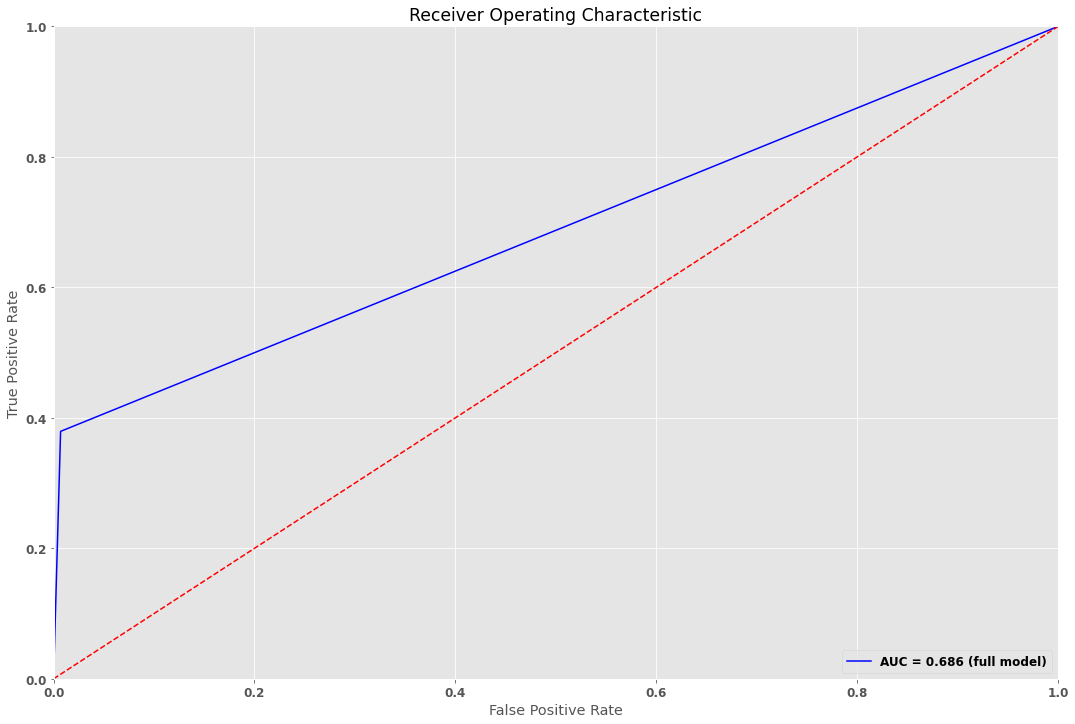

In [118]:
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, predictions)


roc_auc1 = metrics.auc(fpr1, tpr1)



import matplotlib.pyplot as plt
plt.figure(figsize=(18,12))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.3f (full model)' % roc_auc1)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

plt.show()

In [130]:
a = np.array(y_test).ravel()
print(a)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 

In [131]:
b =np.array(predictions)
print(b)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [134]:
print("errors:",abs(b-a).sum())

errors: 42
